# INFO-F-438 - Algorithms in computational biology - 2021

## Assignment 4: Implementing efficient string matching

### Name: Hoang Hai Nam
### M. No.: 443146

Python version used and tested : 3.8

Imported libraries: timeit, pyplot, os, sys, guppy3

Note: None of these libraries are required to run validation codes. They're for graphs and performance analysis

Code to mute prints were taken from here: https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
Code to track memory usage were consulted at: https://web.archive.org/web/20180807190820/http://pkgcore.readthedocs.io/en/latest/dev-notes/heapy.html

# 1. Imports (not needed unless you're planning to run the performance analysis codes yourself)

In [35]:
import timeit
import matplotlib.pyplot as plt
import os, sys
from guppy import hpy

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# 2. Functions

In [36]:
def enter(a, g, output, newstate):
    """Inputs: word, goto function, output function, newstate
    Output: goto function, output function and newstate
    Inserts into the goto graph a path that spells out the word (a)"""
    state = 0
    # in the paper's pseudocode they set j = 1. THIS IS AN INDEX DECLEARATION
    # would assume that their indexes start at 1, python's indices however start at 0
    # todo: take notice whenever there's an index being declared as 1 in the paper
    j = 0
    # while g(state, a) != fail
    while (state, a[j]) in g:
        state = g[(state, a[j])]
        j += 1
    # for p <- j until m(last index of a)
    for p in range(j, len(a)):
        newstate += 1
        g[(state, a[p])] = newstate
        state = newstate
    # initialising state for output
    if state not in output:
        output[state] = []
    # add word to state of output
    # todo important! cannot use extend here, breaks(merge) overlapping keywords
    output[state].append(a)
    return g, output, newstate


def gbuilder(k):
    """Inputs: a set of keywords {}
    Outputs: the goto function, partially computed output function, pool of letters of the keys
    builds a goto function and partially builds the output function"""
    newstate = 0
    # pool of all letters of keywords, we can check check every possible letter in the last loop
    lpool = []
    # initiation of goto function, dictionary with a tuple as key
    g = dict()
    # initiation of output function dictionary with
    output = dict()
    # first loop
    # loops through all keywords in k
    for word in k:
        # loops through letters within word to build letter pool
        for letter in word:
            if letter not in lpool:
                lpool.append(letter)
        # applying enter() to every word
        g, output, newstate = enter(word, g, output, newstate)
    # second loop
    for a in lpool:
        # synnonym for g(0, a) == fail
        if (0, a) not in g:
            g[(0, a)] = 0
    return g, output, lpool


def fbuilder(g, output, lpool):
    """Inputs: goto function, partial output function, letters pool
    Outputs: The failure function and the complete output function"""
    # queue initialisation, empty as described by pseudocode
    queue = []
    f = {}
    # for g(0, a) != fail and = s
    for a in lpool:
        # and != 0
        if g[(0, a)] != 0:
            queue.append(g[(0, a)])
            f[g[(0, a)]] = 0
    while queue:
        # destroys index 0 and apply it to r
        r = queue.pop(0)
        # for each a such that g(r,a) = s != fail
        for a in lpool:
            if (r, a) in g:
                s = g[(r, a)]
                queue.append(s)
                state = f[r]
                # while g(state,a) = fail, do state = f(state)
                while (state, a) not in g:
                    state = f[state]
                f[s] = g[(state, a)]
                if s not in output:
                    output[s] = []
                # here these 2 ifs are seperated because if s is not in f and we request f[s]
                # right away we'll get an index out of range error todo find a neater way ?
                if s in f:
                    # finding intersection between output(s) and output(fs)
                    if f[s] in output:
                        output[s].extend(output[f[s]])
    return f, output


def deltabuilder(g, f, lpool):
    """inputs: goto function g, failure function f, letter pool lpool
    outputs: delta function, deterministic finite automaton
    essentially merges g and f into one function, saves on performance
    by eliminating failure state transition in the pattern matching machine"""
    queue = []
    delta = dict()
    # loops through all the letters
    for a in lpool:
        # applying null state of goto to delta
        delta[(0, a)] = g[(0, a)]
        if g[(0, a)] != 0:
            queue.append(g[(0, a)])
    while queue:
        # destroys first queue element and apply it to r
        r = queue.pop(0)
        # for each a such that g(r,a) = s != fail
        # loops through all letters a
        for a in lpool:
            # if s=(g(r,a)) != fail
            if (r, a) in g:
                s = g[(r, a)]
                queue.append(s)
                delta[(r, a)] = s
            else:
                delta[(r, a)] = delta[(f[r], a)]
    return delta


def buildprofile(kw, delta=False):
    """Inputs: list of keywords, delta
    Outputs: delta, output functions, lpool if delta
    or goto, failure, output functions and lpool"""
    goto = gbuilder(kw)
    failure = fbuilder(goto[0], goto[1], goto[2])
    # goto == goto[0]
    # failure == failure[0]
    # output == failure[1]
    # lpool == goto[2]
    if delta:
        # return (delta, output, lpool)
        return deltabuilder(goto[0], failure[0], goto[2]), failure[1], goto[2]
    else:
        # return (goto, failure, output, lpool)
        return goto[0], failure[0], failure[1], goto[2]


def patternmatcher(txt, g, f, output, lpool, verbose=True):
    """inputs: target text string, goto and failure function constructed from keywords,
    pool of letters of keywords.
    outputs: None, function executes prints if verbose=T
    else: Dictionary of keywords and their positions within the txt as a list"""
    state = 0
    # initiating dictionary of keywords and their positions stored as list
    apps = dict()
    # loops through all LETTERS withing a string
    for i in range(len(txt)):
        if txt[i] in lpool:
            # consulting failure function for fail states within g
            while (state, txt[i]) not in g:
                state = f[state]
            state = g[(state, txt[i])]
            if state in output:
                if output[state]:
                    # deciding between verbose or not is here
                    if verbose:
                        for kw in output[state]:
                            # right now it is calibrated for indices that start at 1 and
                            # unlike python's indices which start at 0
                            print("Pattern", "{" + kw + "}", "found at position", i - len(kw) + 2)
                    else:
                        for kw in output[state]:
                            if kw not in apps:
                                apps[kw] = []
                            # appending positions to apps
                            apps[kw].append(i - len(kw) + 2)
    if not verbose:
        return apps


def deltamatcher(txt, delta, output, lpool, verbose=True):
    """inputs: target text string, delta function constructed from goto and failure functions,
    pool of letters of keywords.
    outputs: None, function executes prints, if verbose=T
    else: ictionary of keywords and their positions within the txt
    Alternate version of pattern matcher that uses delta instead of goto and failure"""
    state = 0
    apps = dict()
    for i in range(len(txt)):
        if txt[i] in lpool:
            # here the while loop of possible multiple failure state transition is replace by delta
            state = delta[(state, txt[i])]
            if state in output:
                if output[state]:
                    if verbose:
                        for kw in output[state]:
                            # right now it is calibrated for indices that start at 1 and
                            # unlike python's indices which start at 0
                            print("Pattern", "{" + kw + "}", "found at position", i - len(kw) + 2)
                    else:
                        for kw in output[state]:
                            if kw not in apps:
                                apps[kw] = []
                            apps[kw].append(i - len(kw) + 2)
    if not verbose:
        return apps


def patternhelper(keywords, textstring, delta=False, verbose=True):
    """inputs: keywords, target textstrings, and delta[BOOL]
    outputs: None"""
    # verbose case
    if verbose:
        # delta case
        if delta:
            dee, ohh, pool = buildprofile(keywords, delta)
            deltamatcher(textstring, dee, ohh, pool)
        # default case, verbose = True, delta = False
        else:
            gee, eff, ohh, pool = buildprofile(keywords, delta)
            patternmatcher(textstring, gee, eff, ohh, pool)
    else:
        if delta:
            dee, ohh, pool = buildprofile(keywords, delta)
            res = deltamatcher(textstring, dee, ohh, pool, verbose=False)
        else:
            gee, eff, ohh, pool = buildprofile(keywords, delta)
            res = patternmatcher(textstring, gee, eff, ohh, pool, verbose=False)
        # non verbose, compact case
        for kw in res:
            print("Pattern", "{" + kw + "}", "was found", len(res[kw]), "times, at positions", res[kw])


def paragrapher(keywords, paralist, delta=False, verbose=True):
    """inputs: keywords, target textstrings, and delta[BOOL]
        outputs: None"""
    # default conditions, verbose=T
    if verbose:
        if delta:
            dee, ohh, pool = buildprofile(keywords, delta)
            for i in range(len(paralist)):
                print("--------------------")
                print("Within Paragraph", i + 1, ":")
                print("--------------------")
                # putting line into pattern matcher, prints as the machine goes through letter by letter
                deltamatcher(paralist[i], dee, ohh, pool)
        else:
            gee, eff, ohh, pool = buildprofile(keywords, delta)
            # loops through each line
            for i in range(len(paralist)):
                print("--------------------")
                print("Within Paragraph", i + 1, ":")
                print("--------------------")
                patternmatcher(paralist[i], gee, eff, ohh, pool)
    # alt condition, verbose=False
    else:
        if delta:
            dee, ohh, pool = buildprofile(keywords, delta)
            # loops line by line in text, or element within a list
            for i in range(len(paralist)):
                print("--------------------")
                print("Within Paragraph", i + 1, ":")
                print("--------------------")
                res = deltamatcher(paralist[i], dee, ohh, pool, verbose=False)
                for kw in res:
                    print("Pattern", "{" + kw + "}", "was found", len(res[kw]), "times, at positions", res[kw])
        else:
            gee, eff, ohh, pool = buildprofile(keywords, delta)
            for i in range(len(paralist)):
                print("--------------------")
                print("Within Paragraph", i + 1, ":")
                print("--------------------")
                res = patternmatcher(paralist[i], gee, eff, ohh, pool, verbose=False)
                for kw in res:
                    print("Pattern", "{" + kw + "}", "was found", len(res[kw]), "times, at positions", res[kw])


def plotruntime(f,r,trials=1,figsize=[3,3]):
    Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r,Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")

    
def plotruntimes(functions,labels,r,trials=5,figsize=[3,3]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()

# 3. Function Validations

All the validations in this section will mirror the example illustrated and used in the paper "Efficient string matching: an aid to bibliographic search" by Aho and Corasick.

looking for keywords {he, she, his, hers} within the text string "ushers"

In [3]:
keywords = {"he", "she", "his", "hers"}
textstring = "ushers"

## Goto function builder and the goto function itself

In [4]:
g = gbuilder(keywords)
# g is a 3-tuple containing, in order, goto function, partial output function and letter pool
print("The goto function:")
print(g[0]) # first of the tuple
print("The partial output function:")
print(g[1])
print("The letter pool:")
print(g[2])

The goto function:
{(0, 'h'): 1, (1, 'e'): 2, (0, 's'): 3, (3, 'h'): 4, (4, 'e'): 5, (2, 'r'): 6, (6, 's'): 7, (1, 'i'): 8, (8, 's'): 9, (0, 'e'): 0, (0, 'r'): 0, (0, 'i'): 0}
The partial output function:
{2: ['he'], 5: ['she'], 7: ['hers'], 9: ['his']}
The letter pool:
['h', 'e', 's', 'r', 'i']


## Failure function builder, the produced failure and output functions

In [5]:
f = fbuilder(g[0], g[1], g[2]) # feeding failure builder the goto function, partial output and lpool
print("The failure function:")
print(f[0])
print("The output function:")
print(f[1])

The failure function:
{1: 0, 3: 0, 2: 0, 8: 0, 4: 1, 6: 0, 9: 3, 5: 2, 7: 3}
The output function:
{2: ['he'], 5: ['she', 'he'], 7: ['hers'], 9: ['his'], 8: [], 4: [], 6: []}


## Delta function builder and the produced delta function

In [6]:
d = deltabuilder(g[0], f[0], g[2])
print("The delta function:")
print(d)

The delta function:
{(0, 'h'): 1, (0, 'e'): 0, (0, 's'): 3, (0, 'r'): 0, (0, 'i'): 0, (1, 'h'): 1, (1, 'e'): 2, (1, 's'): 3, (1, 'r'): 0, (1, 'i'): 8, (3, 'h'): 4, (3, 'e'): 0, (3, 's'): 3, (3, 'r'): 0, (3, 'i'): 0, (2, 'h'): 1, (2, 'e'): 0, (2, 's'): 3, (2, 'r'): 6, (2, 'i'): 0, (8, 'h'): 1, (8, 'e'): 0, (8, 's'): 9, (8, 'r'): 0, (8, 'i'): 0, (4, 'h'): 1, (4, 'e'): 5, (4, 's'): 3, (4, 'r'): 0, (4, 'i'): 8, (6, 'h'): 1, (6, 'e'): 0, (6, 's'): 7, (6, 'r'): 0, (6, 'i'): 0, (9, 'h'): 4, (9, 'e'): 0, (9, 's'): 3, (9, 'r'): 0, (9, 'i'): 0, (5, 'h'): 1, (5, 'e'): 0, (5, 's'): 3, (5, 'r'): 6, (5, 'i'): 0, (7, 'h'): 4, (7, 'e'): 0, (7, 's'): 3, (7, 'r'): 0, (7, 'i'): 0}


## Pattern matching machine, basic case as presented in the paper

In [7]:
# inputs are: goto, failure, output, lpool
patternmatcher(textstring, g[0], f[0], f[1], g[2])

Pattern {she} found at position 2
Pattern {he} found at position 3
Pattern {hers} found at position 3


## Alt pattern matching machine using delta function, basic case as presented in the paper

In [8]:
# inputs are: delta, output, lpool
deltamatcher(textstring, d, f[1], g[2])

Pattern {she} found at position 2
Pattern {he} found at position 3
Pattern {hers} found at position 3


## Pattern matching with prints in a compact format

In [9]:
patternhelper(keywords,textstring,delta=False, verbose=False)

Pattern {she} was found 1 times, at positions [2]
Pattern {he} was found 1 times, at positions [3]
Pattern {hers} was found 1 times, at positions [3]


# 4. Code validation

This section will verify the requested pattern searching within the assignment description to look for the following keywords as words: {pattern, tree, state, prove, the, it}.

This code works if the script is in the same directory as the text file containing the text with each line/paragraph delimited by \n. 

### Take note that this is CASE SENSITIVE pattern searching, i.e: The =/= the.

This is easily changable by lowercase-ing the inputs with: 

    for i in range(len(text)):
        text[i] = text[i].lower()

The default textfile name is fulltext.txt

There'll be 2 modifiers, delta which decides on using the deterministic finite automaton suggested in point 6 of the paper on eliminating failure state transitions. And verbose which decides on the print format for pattern matching, default is like that in the paper, which scans the entire text and prints for every pattern matched. When verbose=False, the prints will be summarised instead.

There's essentially no change in the print outputs when using delta, this is mostly for verification purposes that the delta function works as intended.

For my code I have 2 different helper functions, patternhelper() and paragrapher(). For demonstration purposes paragrapher() was used as it receives lists of strings as inputs, each member in the list represents a line or paragraph within the textfile. The only practical difference in these 2 helper functions are the inputs and prints. As the positions outputted by paragrapher() are that within the paragraph and not the whole text.

In [10]:
zingers = {"pattern", "tree", "state", "prove", "the", "it"}
textfile = open('fulltext.txt', mode='r', encoding="utf-8")
text = textfile.readlines()
textfile.close()

## Default, verbose case

In [11]:
paragrapher(zingers, text, delta=False, verbose=True)

--------------------
Within Paragraph 1 :
--------------------
Pattern {the} found at position 17
Pattern {tree} found at position 72
Pattern {pattern} found at position 133
Pattern {it} found at position 174
Pattern {the} found at position 194
Pattern {tree} found at position 224
Pattern {the} found at position 233
Pattern {the} found at position 262
Pattern {pattern} found at position 266
Pattern {the} found at position 314
Pattern {the} found at position 336
Pattern {pattern} found at position 342
Pattern {the} found at position 360
Pattern {the} found at position 374
--------------------
Within Paragraph 2 :
--------------------
Pattern {it} found at position 104
Pattern {the} found at position 105
Pattern {pattern} found at position 109
Pattern {prove} found at position 150
Pattern {the} found at position 161
Pattern {tree} found at position 173
Pattern {it} found at position 198
Pattern {state} found at position 202
Pattern {pattern} found at position 208
Pattern {the} found at p

## Default, compact case

In [12]:
paragrapher(zingers, text, delta=False, verbose=False)

--------------------
Within Paragraph 1 :
--------------------
Pattern {the} was found 8 times, at positions [17, 194, 233, 262, 314, 336, 360, 374]
Pattern {tree} was found 2 times, at positions [72, 224]
Pattern {pattern} was found 3 times, at positions [133, 266, 342]
Pattern {it} was found 1 times, at positions [174]
--------------------
Within Paragraph 2 :
--------------------
Pattern {it} was found 3 times, at positions [104, 198, 315]
Pattern {the} was found 5 times, at positions [105, 161, 269, 299, 326]
Pattern {pattern} was found 3 times, at positions [109, 208, 340]
Pattern {prove} was found 1 times, at positions [150]
Pattern {tree} was found 1 times, at positions [173]
Pattern {state} was found 1 times, at positions [202]
--------------------
Within Paragraph 3 :
--------------------
Pattern {the} was found 2 times, at positions [27, 69]
Pattern {it} was found 2 times, at positions [49, 100]


## Delta, verbose case

In [13]:
paragrapher(zingers, text, delta=True, verbose=True)

--------------------
Within Paragraph 1 :
--------------------
Pattern {the} found at position 17
Pattern {tree} found at position 72
Pattern {pattern} found at position 133
Pattern {it} found at position 174
Pattern {the} found at position 194
Pattern {tree} found at position 224
Pattern {the} found at position 233
Pattern {the} found at position 262
Pattern {pattern} found at position 266
Pattern {the} found at position 314
Pattern {the} found at position 336
Pattern {pattern} found at position 342
Pattern {the} found at position 360
Pattern {the} found at position 374
--------------------
Within Paragraph 2 :
--------------------
Pattern {it} found at position 104
Pattern {the} found at position 105
Pattern {pattern} found at position 109
Pattern {prove} found at position 150
Pattern {the} found at position 161
Pattern {tree} found at position 173
Pattern {it} found at position 198
Pattern {state} found at position 202
Pattern {pattern} found at position 208
Pattern {the} found at p

## Delta, compact case

In [14]:
paragrapher(zingers, text, delta=True, verbose=False)

--------------------
Within Paragraph 1 :
--------------------
Pattern {the} was found 8 times, at positions [17, 194, 233, 262, 314, 336, 360, 374]
Pattern {tree} was found 2 times, at positions [72, 224]
Pattern {pattern} was found 3 times, at positions [133, 266, 342]
Pattern {it} was found 1 times, at positions [174]
--------------------
Within Paragraph 2 :
--------------------
Pattern {it} was found 3 times, at positions [104, 198, 315]
Pattern {the} was found 5 times, at positions [105, 161, 269, 299, 326]
Pattern {pattern} was found 3 times, at positions [109, 208, 340]
Pattern {prove} was found 1 times, at positions [150]
Pattern {tree} was found 1 times, at positions [173]
Pattern {state} was found 1 times, at positions [202]
--------------------
Within Paragraph 3 :
--------------------
Pattern {the} was found 2 times, at positions [27, 69]
Pattern {it} was found 2 times, at positions [49, 100]


# 5. Code Walkthrough

For all of the automatas(i.e: goto, failure, output, delta), I stored the information needed for them to function within python dictionaries. This is to me the most intuitive and efficient way of making a static function that only serves 2 operations, storing and calling. 

For example, for a variable a and a function f(x). f(x) would support storing some information, i.e: f(a) <- 7. As well as returning such information when called, i.e: f(a) = 7. 

In a true sense f(x) isn't really a mathematical(or pythonic) function but rather a storing object for pre-calculations done elsewhere.

As for the functions delta and goto which recieves 2 variables, state and symbol, not much really change, as I can always treat the inputs as a tuple (here it's a 2-ple). 

As for the algorithms, I closely mirror those that were described in the paper using pseudocodes. Since the explainations on how the automatas were built in the paper are very exhaustive and as a result, intuitive, I will summarise the functioning of the non-pythonic functions(automatas) instead of repeating what's already well explained in the paper.

The only deviation from the pseudocode is the letterpools, but I'm not sure how else I would keep track of all the letters that are concerned within the goto function.

### Goto function
The goto function is a trie of the keywords, recieves as input a state number, a symbol, and returns the next state to assume.
### Failure function
The failure function is a fallback for looking up state+symbol when the goto function returns a fail. For each state, f(state) has a redirect to a fallback state for when g(state,symbol) returns a fail.
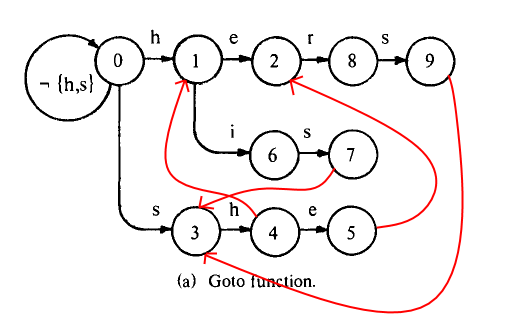
This modified figure from the paper summerise the failure function's extra information for the trie, represented by red arrows. All nodes that do not have a red arrow coming from it, on fail states they return to state 0.
### Output function
The output function contains all the valid states that the pattern matching machine is at when it goes past keywords.
### Delta function
The use of the delta or next move function seeks to eliminate failure state transitions mapped by the failure function. A pattern matching machine that uses the next move function, in this paper such function is called deltamatcher(), for all failstates, there's only one state transition which is guided by delta function. In essense the delta function is a merge/calculated by a goto and a failure function that precalculates all multiple fail-states transitions. The authors describe the use of a delta function may eliminate up to 50% of fail state transitions(which is represented by the loop: 
    while (state, txt[i]) not in g:
        state = f[state]
within the patternmatcher() function. By replacing this while loop with a single call to the delta function, multiple fail states transitions are eliminated. However this time saving comes at a cost of slightly more memory, as well as the fact that the pattern matching machine stays at state 0 for most of its runtime in practice.


# 6. Discussions

In [15]:
threefile = open('threes.txt', mode='r', encoding="utf-8")
threes = threefile.readlines()
threefile.close()
for i in range(len(threes)):
    threes[i] = threes[i].strip()
# threes is a list of all 3 letter english words
textfile = open('suomi.txt', mode='r', encoding="utf-8")
text = textfile.read()
textfile.close()

## Runtime performance

For these next tests, I vary the keywords as n, which are 3 letters english words(probably?). n here represents the number of keywords in play, as well as the total lengths of keywords. The target text is static and is the first 3 paragraphs of the wikipedia page for Finland.
Theoretically the runtime of the Aho-Corasick should be in linear time to total keyword length.

### Impacts by delta

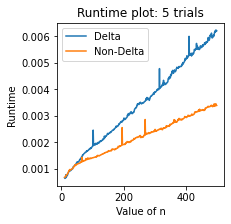

In [16]:
with HiddenPrints():
    plotruntimes([lambda n:patternhelper(threes[:n], text, delta = True, verbose = False),
              lambda n:patternhelper(threes[:n], text, delta = False, verbose = False)],
             ["Delta","Non-Delta"],range(10,500))

This result is slightly surprising to me as I expected running the function with delta instead of goto and failure would slightly improve on runtime, however it is the opposite. This is however, possibly explained by the fact that every time delta is requested for a search, it requires the calculation of merging goto and failure. As such for each different delta pattern matching cases it takes more time to complete a simple search operations. However, meaningful time savings may be achieved if we bring the same delta function(and forcibly the same keywords) and apply it on multiple tests and reusing a pre-baked delta function. However for single-search operations, delta significantly reduces efficiency.

Within this performance tests however, we vary the keywords and not the target text.

### Impacts by verbose

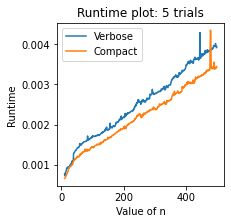

In [17]:
with HiddenPrints():
    plotruntimes([lambda n:patternhelper(threes[:n], text, delta = False, verbose = True),
              lambda n:patternhelper(threes[:n], text, delta = False, verbose = False)],
             ["Verbose","Compact"],range(10,500))

Verbose here adds a flat rate to runtime, possibly due to the increase in amount of print() calls compared to a compact case

Overall we can verify the linear runtime to total keyword length through these graphs.

## Memory perfomance (beta)

I apologise if this seems messy and possibly completely wrong, this is the first time I'm trying to measure memory performance.

Running the codes below require the library guppy3

###  Total memory usage by non-delta case

In [37]:
hp = hpy()
zingers = {"finland", "euro", "finnish", "world", "war", "it"}
textfile = open('suomi.txt', mode='r', encoding="utf-8")
text = textfile.read()
text = text.lower()
textfile.close()
# starting point of mem measurement
hp.setrelheap()
patternhelper(zingers, text, delta=False, verbose=False)
h = hp.heap()
print(h)

Pattern {finland} was found 21 times, at positions [1, 70, 116, 173, 229, 475, 530, 993, 1297, 1433, 1496, 1599, 1821, 1906, 2037, 2166, 2237, 2527, 2615, 2814, 3014]
Pattern {finnish} was found 6 times, at positions [10, 182, 685, 1420, 1518, 1997]
Pattern {euro} was found 5 times, at positions [311, 1624, 2696, 2724, 2779]
Pattern {it} was found 26 times, at positions [319, 343, 600, 662, 680, 815, 950, 1010, 1207, 1714, 1778, 1843, 1850, 2188, 2196, 2218, 2318, 2489, 2511, 2548, 2610, 2791, 2922, 2954, 3061, 3240]
Pattern {world} was found 7 times, at positions [774, 1689, 2023, 2305, 3046, 3136, 3268]
Pattern {war} was found 8 times, at positions [1428, 2011, 2029, 2083, 2108, 2145, 2160, 2311]
Partition of a set of 24 objects. Total size = 2713 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0      3  12     1360  50      1360  50 types.FrameType
     1      3  12      192   7      1552  57 types.MethodType
     2      1   4      176   6      

###  Total memory usage by delta case

In [40]:
hp = hpy()
zingers = {"finland", "euro", "finnish", "world", "the", "it"}
textfile = open('suomi.txt', mode='r', encoding="utf-8")
text = textfile.read()
text = text.lower()
textfile.close()
# starting point of mem measurement
hp.setrelheap()
patternhelper(zingers, text, delta=True, verbose=False)
h = hp.heap()
print(h)

Pattern {finland} was found 21 times, at positions [1, 70, 116, 173, 229, 475, 530, 993, 1297, 1433, 1496, 1599, 1821, 1906, 2037, 2166, 2237, 2527, 2615, 2814, 3014]
Pattern {finnish} was found 6 times, at positions [10, 182, 685, 1420, 1518, 1997]
Pattern {the} was found 62 times, at positions [157, 305, 357, 377, 397, 426, 449, 463, 486, 519, 645, 694, 717, 737, 770, 781, 827, 834, 869, 876, 898, 1036, 1065, 1137, 1212, 1246, 1274, 1287, 1369, 1376, 1416, 1466, 1545, 1614, 1672, 1685, 1722, 1779, 1877, 1958, 1993, 2052, 2072, 2091, 2133, 2156, 2288, 2319, 2440, 2542, 2630, 2648, 2692, 2720, 2775, 3042, 3074, 3105, 3132, 3162, 3206, 3264]
Pattern {euro} was found 5 times, at positions [311, 1624, 2696, 2724, 2779]
Pattern {it} was found 26 times, at positions [319, 343, 600, 662, 680, 815, 950, 1010, 1207, 1714, 1778, 1843, 1850, 2188, 2196, 2218, 2318, 2489, 2511, 2548, 2610, 2791, 2922, 2954, 3061, 3240]
Pattern {world} was found 7 times, at positions [774, 1689, 2023, 2305, 3046, 

From these 2 results we can see that in the case of using next move function delta, the memory usage increased from 2713 bytes to 2865 bytes. Consistent of the author's statement on the increased memory usage of the next-move function. However the author's notion of memory might've been peak usage and here this is total memory usage.